# Tutorial: Preparing site data for liquefaction analysis with the OQ-MBTK

This tutorial for preparing site data for liquefaction analysis with the OQ-MBTK is a Jupyter notebook, which containts text as well as exectuable Python code.  The notebook can be downloaded along with the sample data from [here][tut].

[tut]: https://github.com/GEMScienceTools/oq-mbtk/tree/master/tutorials/sep

First, we need to import the Python modules that we'll use.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from openquake.sep.utils import(
    sample_raster_at_points,
    vs30_from_slope
)

We will be working with two different liquefaction models in this analysis, the [HAZUS model][oq_haz] by the US Federal Emergency Management Agency (FEMA), and a statistical model by Zhu et al (2015) that we'll call the [Zhu model][oq_zhu]. 

These models require different parameters to characterize the liquefaction susceptibility and probabilities at each site.  The HAZUS model relies on a classification of each site into a liquefaction susceptibility category, based on geotechnical parameters at the site. The Zhu model relies on quantitative parameters that may, in principle, be estimated through processing of a digital elevation model.


[oq_haz]: https://gemsciencetools.github.io/oq-mbtk/contents/sep_docs/sep_models.html#hazus
[oq_zhu]: https://gemsciencetools.github.io/oq-mbtk/contents/sep_docs/sep_models.html#zhu-et-al-2015



## Joining site information to site locations

We'll start with a basic CSV file with the longitude and latitude of the sites for our analysis as well as the geologic unit at that site.  The geologic unit at each site has been added through a [spatial join][qgis_join] of the site locations with a geologic map layer in QGIS.

[qgis_join]: https://www.qgistutorials.com/en/docs/performing_spatial_joins.html

### HAZUS site parameters

The HAZUS model requires that we have liquefaction susceptibility categories and groundwater depths for all sites.  We'll get these by mapping the geologic unit to these parameters, and the assigning the parameters to each site based on the geologic unit through a database join.

In [2]:
# Read in the sites CSV with pandas
sites = pd.read_csv('./tutorial_data/cali_sites_w_units.csv')

sites.head()

,lon,lat,unit
0,-76.540896,3.350158,TQplp
1,-76.544763,3.350644,TQplp
2,-76.528079,3.346550,TQplp
3,-76.529860,3.356627,TQplp
4,-76.527918,3.351601,TQplp


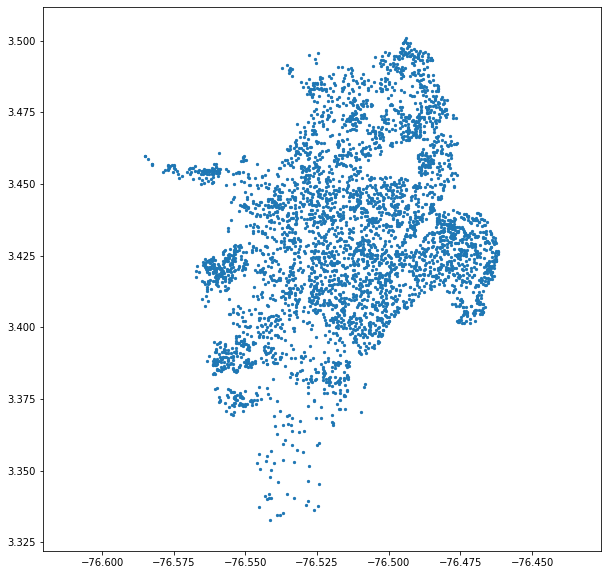

In [3]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5)

plt.show()

Now, we'll load another file that has the geologic descriptions for each unit as well as the HAZUS liquefaction susceptibility category for each unit.  (The file also has the geotechnical parameters that are used for [landslide analysis](./landslide_site_prep.ipynb) but are not used here.)

The liquefaction susceptibility category has been estimated based on the geologic description for that unit, as well as the location of the unit with respect to water bodies (rivers and creeks) from inspection of the geologic map. The guidelines for this assignment can be found in the [HAZUS Manual][hzm], Section 4-21. If you are uncertain of how to proceed, please contact your local geologist or geotechnical engineer.

[hzm]: https://www.hsdl.org/?view&did=1276


In [4]:
unit_table = pd.read_csv('./tutorial_data/cali_units.csv')

unit_table

,unit,friction_mid,friction_unc,cohesion_mid,cohesion_unc,saturation,dry_density,uscs,type,description,susc_cat
0,Q1,33.5,1.5,0,0,0.20,2091,SM,silty sands,old wetlands,m
1,Q2,27.0,5.0,50000,0,0.40,1734,OL,organic silts,swamp deposits,h
2,Q3,33.5,1.5,0,0,0.30,2091,SM,silty sands,river channel deposits,vh
3,Q4,33.5,1.5,0,0,0.20,2091,SM,silty sands,levee deposits,h
4,Q5,27.0,5.0,50000,0,0.25,1734,OL,organic silts,floodplain deposits,h
5,Q6,38.0,6.0,0,0,0.30,2091,GP,"poorly graded gravel w/ sand, no fines",active alluvial fill,vh
6,Q7,32.5,1.5,62500,1250,0.25,1887,SM,loamy sand,point bar deposits,vh
7,Cono,36.5,3.5,0,0,0.15,2142,GW,"well graded gravel w/ sand, no fines",alluvial fan,l
8,Qt,36.5,3.5,0,0,0.10,2142,GW,"well graded gravel w/ sand, no fines",terrace deposits,m
9,Qc,31.5,3.5,20000,0,0.15,1887,CG,clayey sandy gravels,colluvium,l


Let's make a new table with just the information that we need, which is the liquefaction susceptibility category (called `susc_cat` in this table).

In [5]:
liq_susc_cat = unit_table[['unit', 'susc_cat']]

# set the index to be the unit, for the join below.
liq_susc_cat = liq_susc_cat.set_index('unit')

We'll do a database join on the two tables using Pandas, which will let us take the attributes for each geologic unit and append them to each site based on the geologic unit for that site.

In [6]:
sites = sites.join(liq_susc_cat, on='unit')

sites.head()

,lon,lat,unit,susc_cat
0,-76.540896,3.350158,TQplp,n
1,-76.544763,3.350644,TQplp,n
2,-76.528079,3.346550,TQplp,n
3,-76.529860,3.356627,TQplp,n
4,-76.527918,3.351601,TQplp,n


We also need groundwater depths at each point.  A high-quality analysis would use measured data or at least values interpolated from a map of the water table depth, but we don't have that information available. Instead, we'll just estimate values based on the geologic unit. These units are somewhat spatially arranged so that the groundwater depth probably correlates with the unit, but in the absence of any real data, it's impossible to know how good of an approximation this is.

We'll use a simply Python dictionary with the unit as the key and estimates for groundwater depth in meters as the value.

In [7]:
gwd_map = {'Q1': 0.65,
           'Q2': 0.3,
           'Q3': 0.2,
           'Q4': 0.3,
           'Q5': 0.2,
           'Q6': 0.1,
           'Q7': 0.15,
           'Cono': 1.75,
           'Qt': 1.,
           'Qc': 2.,
           'Qd': 1.25,
           'QvT': 1.2,
           'QvK': 1.2,
           'Q/Kv': 2.5,
           'T': 3.,
           'TQplp': 3.,
           'Kv': 4.
           }

sites['gwd'] = sites.apply(lambda x: gwd_map[x.unit], axis=1)

In [8]:
sites.head()

,lon,lat,unit,susc_cat,gwd
0,-76.540896,3.350158,TQplp,n,3.0
1,-76.544763,3.350644,TQplp,n,3.0
2,-76.528079,3.346550,TQplp,n,3.0
3,-76.529860,3.356627,TQplp,n,3.0
4,-76.527918,3.351601,TQplp,n,3.0


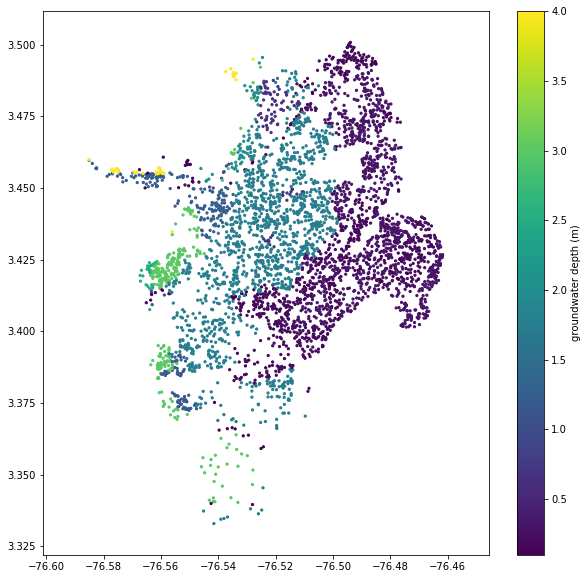

In [9]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, c=sites.gwd)

plt.colorbar(label='groundwater depth (m)')

plt.show()

### Zhu site parameters

The Zhu model was developed to use parameters that can be derived from a digital elevation model.  

One of these, the Vs30 value, can be calculated from a DEM quite easily, as long as the DEM has a resolution around 1 km. First, the slope should be calculated (which is very easy to do in a GIS program), and then the Vs30 can be calculated from the slope using Wald and Allen's methods [(2007)][wa_2007].

The `openquake.sep.utils` module has some functions to calculate Vs30 from slope, and to get the values of a raster at any point.  We'll use these functions to get the Vs30 values from a slope raster for each of our sites.

[wa_2007]: https://pubs.geoscienceworld.org/ssa/bssa/article/97/5/1379/146527

In [10]:
slo = sample_raster_at_points('./tutorial_data/cali_slope_srtm_1km.tif', sites.lon, sites.lat)

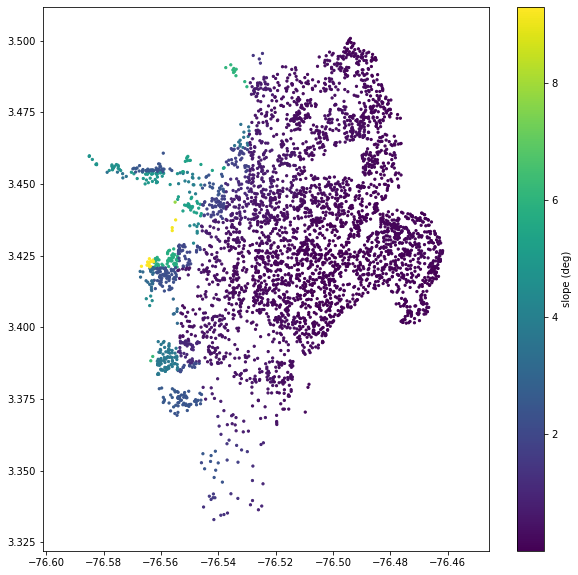

In [11]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, c=slo)

plt.colorbar(label='slope (deg)')

plt.show()

In [12]:
sites['vs30'] = vs30_from_slope(slo, slope_unit='deg', tectonic_region_type='active')

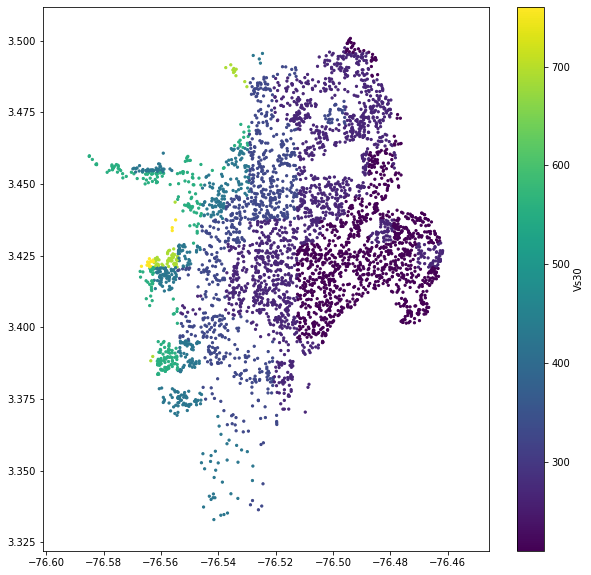

In [13]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, c=sites.vs30)

plt.colorbar(label='Vs30')

plt.show()

Next, we need to get values for the Compound Topographic Index (CTI).  The process is the same, using a raster of CTI values.  (Though it is possible to calculate the CTI from a DEM using algorithms implemented in many GIS packages, in practice the range of the resulting CTI values is incompatible with the CTI values that Zhu et al. used in their calibration. Therefore it is strongly advised to obtain CTI data from a dataset that has a global range of 0-20; we recommend [Marthews et al., 2015](https://www.hydrol-earth-syst-sci.net/19/91/2015/)).

In [14]:
sites['cti'] = sample_raster_at_points('./tutorial_data/ga2_cti_cali.tif', sites.lon, sites.lat)

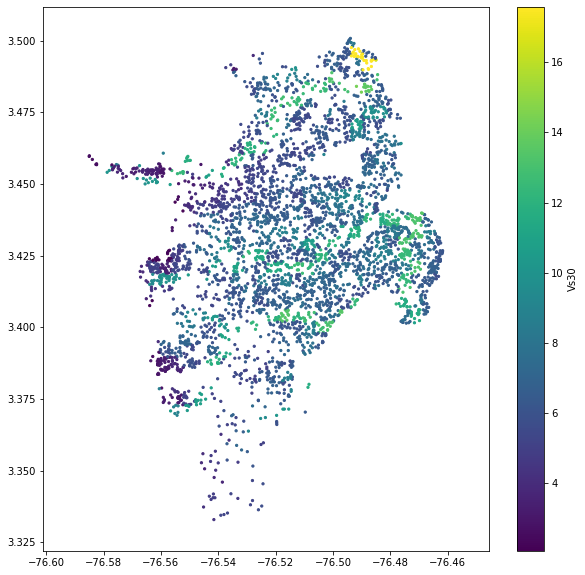

In [15]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, c=sites.cti)

plt.colorbar(label='Vs30')

plt.show()

In [ ]:
## Saving and cleaning up

That's basically it. We just need to save the file and then proceed to the [liquefaction analysis][liq_anal].

[liq_anal]: ./liquefaction_analysis.ipynb

In [16]:
sites.to_csv('./tutorial_data/liquefaction_sites.csv', index=False)